In [ ]:
import gzip
import torch
import pickle
import hashlib
import platform
import numpy as np
import polars as pl
import comp_capacity  # have to import to register custom gym env
import gymnasium as gym

from pathlib import Path
from tqdm.auto import tqdm
from comp_capacity.repr.network import (
    ProgressiveRNN,
    MatrixContainer,
    sample_network,
)
from comp_capacity.repr.uid import generate_hash

In [2]:
# define some folders to save data
if platform.system() == "Darwin":
    save_folder = Path("/Users/wingillis/Library/CloudStorage/SynologyDrive-sync/home/research-projects/computational-capacity")
elif platform.system() == "Linux":
    save_folder = Path("/mnt/e/SynologyDrive/win/synology drive/home/research-projects/computational-capacity")

base_file_name = "network-data-2025-04-24"

In [4]:
device = "cpu"
# if torch.mps.is_available():
#     # run on Mac GPU
#     device = torch.device("mps")
# elif torch.cuda.is_available():
#     # run on NVIDIA GPU
#     device = torch.device("cuda")

In [5]:
# testing out the environment
input_dim = 5
output_dim = 1
env = gym.make("NextStepFunction-v0", function="sinusoidal", steps=input_dim)

In [ ]:
# generates the topology 
p = 0.2
seed = 0
nodes = 1
recurrent = False

torch.manual_seed(seed)

matrices = sample_network(
    n_nodes=nodes,
    connection_prob=p,
    recurrent=recurrent,
    device=device,
)

In [ ]:
# example cell to run env a single step using network outputs
network = ProgressiveRNN(matrices, input_dim=input_dim, output_dim=output_dim, device=device)
obs, info = env.reset(seed=seed)
X = torch.tensor(obs, dtype=torch.float).unsqueeze(0).to(device)

# state variable useful for recurrent networks
state = None

# network returns the final layer output and current state
out, state = network(X, state=state)

# the "loss" is located within the reward. A larger loss is better
obs, reward, terminated, truncated, info = env.step(out.detach().cpu().squeeze().numpy())
print("obs", obs)
print("reward", reward)
print("terminated", terminated)
print("truncated", truncated)
print("info", info)

cat, sizes = matrices.concat()

# example of generating a hash
_hash = generate_hash(matrices)
print("hash", _hash)

obs [-0.08435708  0.58239485  0.42509462 -0.33368781 -0.62032294]
reward -0.17336961266580336
terminated True
truncated False
info {'params': (1.2739233746429086, -0.1321048632913019, 0.6404226504432821), 'function': 'sinusoidal'}
hash 2d9f0bfc6e2d0726bee3b19cf98f664ca505710c5e625bd274f2ca9cd63af7ee


In [ ]:
# TODO: save matrices separately
#  - run in recurrent mode (i.e., a few network steps before taking action)
#  - try running backprop for a few steps to see if I can add improvement
#  - try resampling network parameters multiple times

increase_node_prob = 1 / 1000

p = 0.4
nodes = 2
recurrent = False
n_samples = int(1e6)
num_envs = 10

# `make_vec` vectorizes the environment, so that it can run in "batch" mode
# (i.e., multiple environments at once)
steps = 10
envs = {
    "next-step-sin": gym.make_vec(
        "NextStepFunction-v0",
        function="sinusoidal",
        steps=steps,
        num_envs=num_envs,
        vectorization_mode="async",
    ),
    "next-step-exp": gym.make_vec(
        "NextStepFunction-v0",
        function="exponential",
        steps=steps,
        num_envs=num_envs,
        vectorization_mode="async",
    ),
    "next-step-linear": gym.make_vec(
        "NextStepFunction-v0",
        function="linear",
        steps=steps,
        num_envs=num_envs,
        vectorization_mode="async",
    ),
    "sequence-abab": gym.make_vec(
        "SequentialPatterns-v0",
        pattern="abab",
        steps=steps,
        num_envs=num_envs,
        vectorization_mode="async",
    ),
    "sequence-increase": gym.make_vec(
        "SequentialPatterns-v0",
        pattern="increase",
        steps=steps,
        num_envs=num_envs,
        vectorization_mode="async",
    ),
    "sequence-last": gym.make_vec(
        "SequentialPatterns-v0",
        pattern="last",
        steps=steps,
        num_envs=num_envs,
        vectorization_mode="async",
    ),
}
pbar = tqdm(range(n_samples), desc=f"Sampling networks. {nodes=}")

# trick to get the number of nodes for each sample ahead of time
node_increase_sample = (
    torch.cumsum(torch.rand(n_samples) < increase_node_prob, 0) + nodes
)

# store generated matrices in a queue to keep I/O efficient
matrix_store = {}

df_items = []

for seed in pbar:
    # fix seed for reproducibility
    torch.manual_seed(seed)

    # get number of nodes for this sample
    nodes = node_increase_sample[seed].cpu().item()

    matrices = sample_network(
        n_nodes=nodes,
        connection_prob=p,
        recurrent=recurrent,
        device=device,
    )

    cat, sizes = matrices.concat()
    cat = cat.cpu().numpy()

    _hash = generate_hash(matrices)

    matrix_store[_hash] = (cat, sizes)

    # loop through all initialized environments, run one step through the network
    # NOTE: each network has the same topology, but different random weights
    for env_name, env in envs.items():

        # NOTE: this only works for one-dimensional inputs - future update could handle multi-dimensional inputs
        input_dim = env.observation_space.shape[-1]

        categorical_sample = isinstance(
            env.action_space, (gym.spaces.Discrete, gym.spaces.MultiDiscrete)
        )
        if isinstance(env.action_space, gym.spaces.MultiDiscrete):
            # allows us to sample a categorical action (i.e., up, down, etc)
            output_dim = env.action_space[0].n
        else:
            output_dim = env.action_space.shape[-1]

        network = ProgressiveRNN(
            matrices, input_dim=input_dim, output_dim=output_dim, device=device
        )

        # for this set of environments, we only take one step and then reset
        obs, info = env.reset(seed=seed)
        X = torch.tensor(obs, dtype=torch.float).to(device)
        if obs.ndim == 1:
            X = X.unsqueeze(0)
        state = None
        out, state = network(X, state=state)
        if categorical_sample:
            # sample action from network output
            out = torch.distributions.Categorical(logits=out).sample()
        obs, reward, terminated, truncated, info = env.step(
            out.detach().cpu().squeeze().numpy()
        )

        # integrate data into dataframe
        for i in range(num_envs):
            df_items.append(
                {
                    "id": _hash,
                    "parameter_count": sum(p.numel() for p in network.parameters()),
                    "batch": i,
                    "nodes": nodes,
                    "recurrent": recurrent,
                    "seed": seed,
                    "reward": reward[i],
                    "input_dim": input_dim,
                    "output_dim": output_dim,
                    "env": env_name,
                    "input_len": input_dim,
                    "n_recurrent_edges": torch.tril(matrices.connectivity).sum().item(),
                    "total_steps": 1,
                    "resample": 0,
                }
            )
    # save dataframe every N samples
    if seed % 2_000 == 0 and seed > 0:
        df = pl.DataFrame(df_items)
        df.write_parquet(
            save_folder / f"{base_file_name}.parquet",
            compression_level=5,
        )

        with gzip.open(
            save_folder / f"matrices-seed-{seed}-{base_file_name}.pkl.gz",
            "wb",
            compresslevel=5,
        ) as f:
            pickle.dump(matrix_store, f)
        matrix_store = {}

    pbar.set_description(f"Sampling networks. {nodes=}")

SyntaxError: ':' expected after dictionary key (101936976.py, line 145)

In [ ]:
df = pl.DataFrame(df_items)
df = df.unique(subset=["id", "batch"]).sort("reward", descending=True)
df.write_parquet(
    save_folder / f"{base_file_name}.parquet",
    compression_level=5,
)

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
df = pl.read_parquet(save_folder / f"{base_file_name}.parquet")

In [5]:
df = df.unique(subset=["id", "batch", "env"]).sort("reward", descending=True)

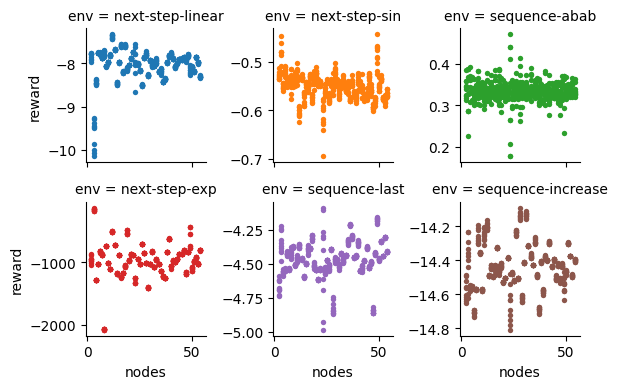

In [15]:
# avg = df.group_by(["nodes", "env"]).agg(pl.col("reward").mean())
avg = df.group_by(["nodes", "batch", "env"]).agg(pl.col("reward").mean())

# larger reward is better
g = sns.FacetGrid(data=avg, col="env", hue="env", height=2, aspect=1, sharey=False, col_wrap=3)
g.map(sns.scatterplot, "nodes", "reward", lw=0, s=15)

In [ ]:
df.head()

id,parameter_count,batch,nodes,recurrent,seed,reward,input_dim,output_dim,env,input_len
str,i64,i64,i64,bool,i64,f64,i64,i64,str,i64
"""6f655a0b0de3716669af36dad9daae…",27,0,1,false,0,-0.369393,10,1,"""next-step-sin""",10
"""6f655a0b0de3716669af36dad9daae…",27,1,1,false,0,-0.508168,10,1,"""next-step-sin""",10
"""6f655a0b0de3716669af36dad9daae…",27,2,1,false,0,-0.613075,10,1,"""next-step-sin""",10
"""6f655a0b0de3716669af36dad9daae…",27,3,1,false,0,-0.559413,10,1,"""next-step-sin""",10
"""6f655a0b0de3716669af36dad9daae…",27,4,1,false,0,-0.870821,10,1,"""next-step-sin""",10


# Future additions

Adding recurrent connections. Only useful with mutliple timesteps (or for reaching a steady state).

Adding envs with multiple timesteps:

- add cartpole
- add pendulum
- add atari games


27